## Imports

In [4]:
#for dealing with data:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import xarray as xr

#for dealing with files:
import os
import re
from scipy.io import readsav
import h5py
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
from urllib.parse import urljoin, urlparse
import time

#for plotting (the rcParams updates are my personal perference to change font and increase fontsize)
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 24,\
                     'xtick.labelsize' : 24,\
                     'ytick.labelsize' : 24,\
                     'axes.titlesize' : 24,\
                     'axes.labelsize' : 24,\
                     'date.autoformatter.minute': '%H:%M' })

# all helper functions for downloading and parsing data
import skymap_data_helper

# for contrast adjustment
import cv2

# for resolution increase
from PIL import Image

### Download Fort Smith 

In [93]:
#download a 8/30/24 fsmi data:
test_date = datetime(2024,8,30)
test_site = 'yknf'
test_dir = './trex-rgb-asi_data' #CHANGE THIS BASED ON WHERE YOU WANT TO PUT THE DATA!

skymap_data_helper.download_trex_rgb_asi_files(test_date,test_site,test_dir)


Accessing https://data.phys.ucalgary.ca/sort_by_project/TREx/RGB/stream0/2024/08/30/...


YKNF ut04: 100%|█████████████████████████████| 10/10 [00:00<00:00, 46863.73it/s]


YKNF ut05: 100%|████████████████████████████| 60/60 [00:00<00:00, 173437.79it/s]


YKNF ut06: 100%|█████████████████████████████| 60/60 [00:00<00:00, 87381.33it/s]


YKNF ut07: 100%|█████████████████████████████| 60/60 [00:00<00:00, 21986.57it/s]


YKNF ut08: 100%|████████████████████████████| 60/60 [00:00<00:00, 160087.94it/s]


YKNF ut09: 100%|████████████████████████████| 60/60 [00:00<00:00, 157090.04it/s]


YKNF ut10: 100%|█████████████████████████████| 27/27 [00:00<00:00, 91107.17it/s]


## Animations: Yellowknife & Fort Smith
1. adjust the contrast of the RGB image
    - alpha = 1.5, beta = 0.0
    - tested on hr 7 and hr 8 w/ low and high activity times
2. make sure that the timeline of the yellow knife and the fort smith data line up
    - YKNF: **yknf--hr4-idx0 4:50:42** - **yknf--hr10-idx522 10:26:06**
    - FSMI: hr4-idx0 4:20:21 - hr10-idx754 10:37:42
    - times to use: hr4 04:50:42 - hr10 10:26:06
    - FSMI shift start idx: 30min,21s=600+7= **fsmi--hr4-idx607**
    - FSMI shift end idx: 11min,36s=220+12=232 --> FSMImax(754)-232= **fsmi--hr10-idx522**
3. generate folder of images containing all of the adjusted RGB images w/ the same contrast
   - define some fixed range (min and max pixel intensity
   - apply the scaling / contrast adjustmnent to every frame
   - SO won't distort the actual variations in the aurora
4. repeat (1-3) for fort smith data
5. create animation
   - split the corresponding time stamp images together OR
   - create separate animations for YKNF and FSMI, then splice the 2 animations together
   - use matplotlib: https://matplotlib.org/stable/gallery/animation/dynamic_image.html

### Edits:
1. too expensive to generate all the pngs, then stich together into an animation 

### Adjusted Contrast Sample

folder: azimuth_elevation_plots/yknf


NameError: name 'rgb_adjusted' is not defined

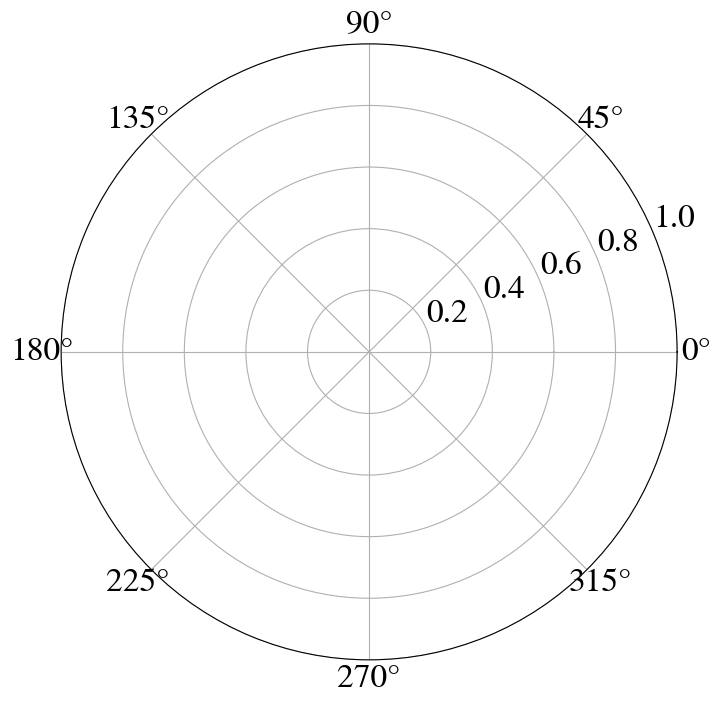

In [2]:
output_folder = "azimuth_elevation_plots"
site_folder_yknf = "yknf" 
site_path = os.path.join(output_folder, site_folder_yknf)
os.makedirs(site_path, exist_ok=True)
print(f"folder: {site_path}")

site_yknf = 'yknf' ## CHANGE FOR FSMI
date = datetime(2024,8,30)
hour = 7
rgb_asi_skymap_lookup_df_yknf = skymap_data_helper.build_rgb_asi_skymap_lookup_table(directory='./trex-rgb-asi_data') #CHANGE TO YOUR SKYMAP DIRECTORY!
rgb_asi_ds= skymap_data_helper.load_rgb_asi_hour_to_xarray(site_yknf, date, hour, rgb_asi_skymap_lookup_df_yknf,data_dir='./trex-rgb-asi_data', skymap_dir='./trex-rgb-asi_data') #CHANGE DIRECTORIES!

# rgb_asi_ds.image = 1200 images, each has 480x553 pixels, each pixel represented by [r, g, b] array --> [1200, 3, 480, 553]
# rgb_asi_ds.image[0] = first image, 3 sets of R,G, B channels, for 480x553 pixels --> [3, 480, 553] 
# print(rgb_asi_ds.image.shape)
# print(rgb_asi_ds.image[0].shape)

# make a polar plot in azimuth and elevation
# time_index = [0,1199] = 7:00 - 7:59:57
# each time_index = 1 is 3 seconds (interval at which images taken)
# each time_index = 200 is 10 minutes
time_index = 1000

R = rgb_asi_ds.image.sel(channel="R").isel(times=time_index).values
G = rgb_asi_ds.image.sel(channel="G").isel(times=time_index).values
B = rgb_asi_ds.image.sel(channel="B").isel(times=time_index).values
RGB = rgb_asi_ds.image.isel(times=time_index).values

azimuth_plot = rgb_asi_ds['azimuth'].values*np.pi/180 #convert to radians too
elevation_plot = rgb_asi_ds['elevation'].values

# Extract time and format it
raw_time = rgb_asi_ds.times.values[time_index]
time_obj = pd.to_datetime(raw_time.decode("utf-8").replace(" UTC", ""))
time_str = time_obj.strftime("%b. %d, %Y %H:%M:%S UT")

# Site label - can adjust to allow for different sites!
site_name_yknf = "Yellowknife" ## CHANGE FOR FSMI
site_name_yknf_short = "yknf" ## CHANGE FOR FSMI

# contrast adjustment: alpha=contrast, beta=brightness
alpha = 1.5
beta = 0
rgb = np.stack([R, G, B], axis=-1)  # shape: (x, y, 3)
rgb_yknf_adjusted = cv2.convertScaleAbs(rgb, alpha=alpha, beta=beta)

#now make a 'true color' version combining all three channels
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(8,8))
scat = ax.scatter(azimuth_plot,elevation_plot,c=rgb_adjusted.reshape(-1, 3)/256,s=1)
ax.set_theta_zero_location("N") # Puts 0° (North) at the top
ax.set_theta_direction(-1) # Clockwise rotation (like a compass)
ax.set_ylim(90, 0);
ax.set_title(f"{site_name_yknf} – {time_str}", pad=30);

datetime_str = time_obj.strftime("%b-%d-%Y_%H:%M:%S")
# fig.savefig(f"{site_path}/{site_name_short}_{datetime_str}.png", dpi=150)


folder: azimuth_elevation_plots/fsmi


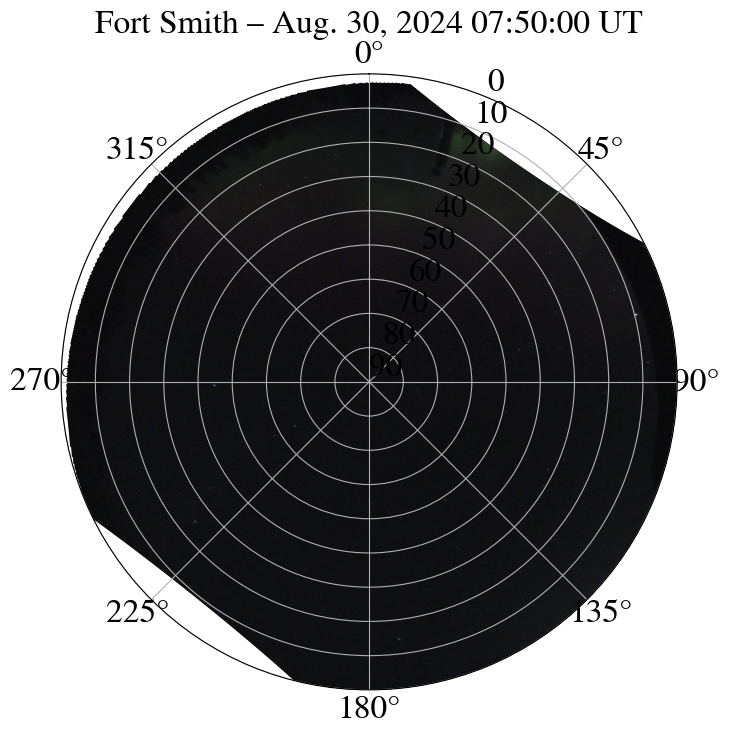

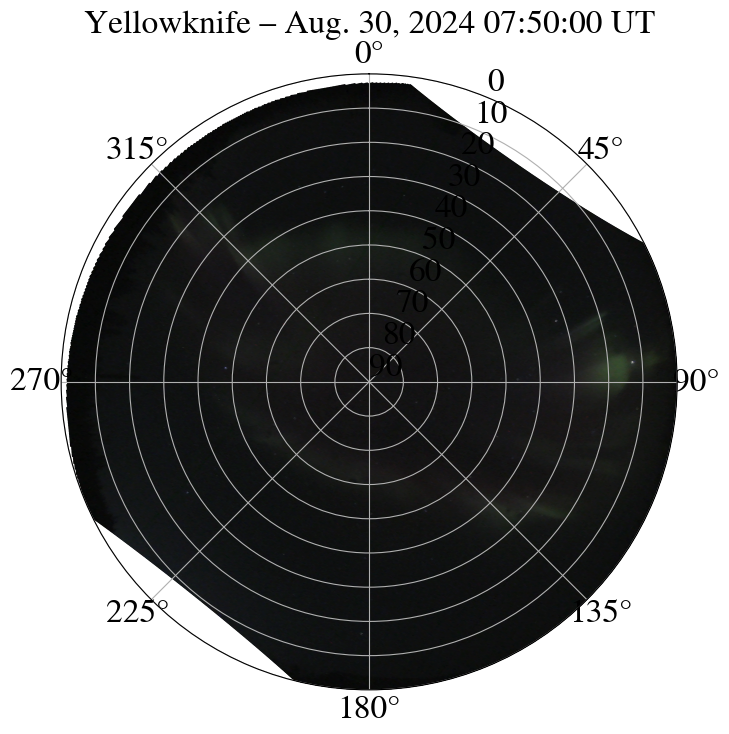

In [3]:
output_folder = "azimuth_elevation_plots"
site_folder_fsmi = "fsmi" 
site_path = os.path.join(output_folder, site_folder_fsmi)
os.makedirs(site_path, exist_ok=True)
print(f"folder: {site_path}")

site_fsmi = 'fsmi' ## CHANGE FOR FSMI
date = datetime(2024,8,30)
hour = 7
rgb_asi_skymap_lookup_df_fsmi = skymap_data_helper.build_rgb_asi_skymap_lookup_table(directory='./trex-rgb-asi_data') #CHANGE TO YOUR SKYMAP DIRECTORY!
rgb_asi_ds= skymap_data_helper.load_rgb_asi_hour_to_xarray(site_fsmi, date, hour, rgb_asi_skymap_lookup_df_fsmi,data_dir='./trex-rgb-asi_data', skymap_dir='./trex-rgb-asi_data') #CHANGE DIRECTORIES!

# rgb_asi_ds.image = 1200 images, each has 480x553 pixels, each pixel represented by [r, g, b] array --> [1200, 3, 480, 553]
# rgb_asi_ds.image[0] = first image, 3 sets of R,G, B channels, for 480x553 pixels --> [3, 480, 553] 
# print(rgb_asi_ds.image.shape)
# print(rgb_asi_ds.image[0].shape)

# make a polar plot in azimuth and elevation
# time_index = [0,1199] = 7:00 - 7:59:57
# each time_index = 1 is 3 seconds (interval at which images taken)
# each time_index = 200 is 10 minutes
time_index = 1000

R = rgb_asi_ds.image.sel(channel="R").isel(times=time_index).values
G = rgb_asi_ds.image.sel(channel="G").isel(times=time_index).values
B = rgb_asi_ds.image.sel(channel="B").isel(times=time_index).values
RGB = rgb_asi_ds.image.isel(times=time_index).values

azimuth_plot = rgb_asi_ds['azimuth'].values*np.pi/180 #convert to radians too
elevation_plot = rgb_asi_ds['elevation'].values

# Extract time and format it
raw_time = rgb_asi_ds.times.values[time_index]
time_obj = pd.to_datetime(raw_time.decode("utf-8").replace(" UTC", ""))
time_str = time_obj.strftime("%b. %d, %Y %H:%M:%S UT")

# Site label - can adjust to allow for different sites!
site_name_fsmi = "Fort Smith" ## CHANGE FOR FSMI
site_name_fsmi_short = "fsmi" ## CHANGE FOR FSMI

# contrast adjustment: alpha=contrast, beta=brightness
alpha = 1.5
beta = 0
rgb = np.stack([R, G, B], axis=-1)  # shape: (x, y, 3)
rgb_fsmi_adjusted = cv2.convertScaleAbs(rgb, alpha=alpha, beta=beta)

#now make a 'true color' version combining all three channels
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(8,8))
scat = ax.scatter(azimuth_plot,elevation_plot,c=rgb_fsmi_adjusted.reshape(-1, 3)/256,s=1)
ax.set_theta_zero_location("N") # Puts 0° (North) at the top
ax.set_theta_direction(-1) # Clockwise rotation (like a compass)
ax.set_ylim(90, 0);
ax.set_title(f"{site_name_fsmi} – {time_str}", pad=30);

# yknf
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(8,8))
scat = ax.scatter(azimuth_plot,elevation_plot,c=rgb_yknf_adjusted.reshape(-1, 3)/256,s=1)
ax.set_theta_zero_location("N") # Puts 0° (North) at the top
ax.set_theta_direction(-1) # Clockwise rotation (like a compass)
ax.set_ylim(90, 0);
ax.set_title(f"{site_name_yknf} – {time_str}", pad=30);

plt.show()

datetime_str = time_obj.strftime("%b-%d-%Y_%H:%M:%S")
# fig.savefig(f"{site_path}/{site_name_short}_{datetime_str}.png", dpi=150)


### YKNF Images

In [49]:
datetime_arr = []

In [50]:
output_folder = "azimuth_elevation_plots"
site_folder = "yknf2" ## CHANGE FOR FSMI
site_path = os.path.join(output_folder, site_folder)
os.makedirs(site_path, exist_ok=True)
print(f"folder: {site_path}")

hour = 7
site = "yknf"
date = datetime(2024,8,30)

rgb_asi_skymap_lookup_df = skymap_data_helper.build_rgb_asi_skymap_lookup_table(directory='./trex-rgb-asi_data') #CHANGE TO YOUR SKYMAP DIRECTORY!
rgb_asi_ds = skymap_data_helper.load_rgb_asi_hour_to_xarray(site, date, hour, rgb_asi_skymap_lookup_df,data_dir='./trex-rgb-asi_data', skymap_dir='./trex-rgb-asi_data') #CHANGE DIRECTORIES!


folder: azimuth_elevation_plots/yknf2


In [51]:
for frame_num in range(800, 1001):
    
    time_index = frame_num
    
    R = rgb_asi_ds.image.sel(channel="R").isel(times=time_index).values
    G = rgb_asi_ds.image.sel(channel="G").isel(times=time_index).values
    B = rgb_asi_ds.image.sel(channel="B").isel(times=time_index).values
    RGB = rgb_asi_ds.image.isel(times=time_index).values
    
    azimuth_plot = rgb_asi_ds['azimuth'].values*np.pi/180 #convert to radians too
    elevation_plot = rgb_asi_ds['elevation'].values
    
    # Extract time and format it
    raw_time = rgb_asi_ds.times.values[time_index]
    time_obj = pd.to_datetime(raw_time.decode("utf-8").replace(" UTC", ""))
    time_str = time_obj.strftime("%b. %d, %Y %H:%M:%S UT")
    
    # Site label - can adjust to allow for different sites!
    site_name = "Yellow Knife" ## CHANGE FOR FSMI
    site_name_short = "yknf" ## CHANGE FOR FSMI
    
    # contrast adjustment: alpha=contrast, beta=brightness
    alpha = 1.5
    beta = 0
    rgb = np.stack([R, G, B], axis=-1)  # shape: (x, y, 3)
    rgb_adjusted = cv2.convertScaleAbs(rgb, alpha=alpha, beta=beta)
    
    #now make a 'true color' version combining all three channels
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(8,8))
    scat = ax.scatter(azimuth_plot,elevation_plot,c=rgb_adjusted.reshape(-1, 3)/256,s=1)
    ax.set_theta_zero_location("N") # Puts 0° (North) at the top
    ax.set_theta_direction(-1) # Clockwise rotation (like a compass)
    ax.set_ylim(90, 0);
    ax.set_title(f"{site_name} – {time_str}", pad=30);
    
    datetime_str = time_obj.strftime("%b-%d-%Y_%H:%M:%S")
    datetime_arr.append(datetime_str)
    fig.savefig(f"{site_path}/{site_name_short}_{datetime_str}.png", dpi=150, bbox_inches="tight")
    
    # free memory
    plt.close(fig)

In [52]:
print(datetime_arr)

['Aug-30-2024_07:40:00', 'Aug-30-2024_07:40:03', 'Aug-30-2024_07:40:06', 'Aug-30-2024_07:40:09', 'Aug-30-2024_07:40:12', 'Aug-30-2024_07:40:15', 'Aug-30-2024_07:40:18', 'Aug-30-2024_07:40:21', 'Aug-30-2024_07:40:24', 'Aug-30-2024_07:40:27', 'Aug-30-2024_07:40:30', 'Aug-30-2024_07:40:33', 'Aug-30-2024_07:40:36', 'Aug-30-2024_07:40:39', 'Aug-30-2024_07:40:42', 'Aug-30-2024_07:40:45', 'Aug-30-2024_07:40:48', 'Aug-30-2024_07:40:51', 'Aug-30-2024_07:40:54', 'Aug-30-2024_07:40:57', 'Aug-30-2024_07:41:00', 'Aug-30-2024_07:41:03', 'Aug-30-2024_07:41:06', 'Aug-30-2024_07:41:09', 'Aug-30-2024_07:41:12', 'Aug-30-2024_07:41:15', 'Aug-30-2024_07:41:18', 'Aug-30-2024_07:41:21', 'Aug-30-2024_07:41:24', 'Aug-30-2024_07:41:27', 'Aug-30-2024_07:41:30', 'Aug-30-2024_07:41:33', 'Aug-30-2024_07:41:36', 'Aug-30-2024_07:41:39', 'Aug-30-2024_07:41:42', 'Aug-30-2024_07:41:45', 'Aug-30-2024_07:41:48', 'Aug-30-2024_07:41:51', 'Aug-30-2024_07:41:54', 'Aug-30-2024_07:41:57', 'Aug-30-2024_07:42:00', 'Aug-30-2024_07

### FSMI Images
- one at a time (way too slow!)
- 7:40 - 7:50

In [15]:
output_folder = "azimuth_elevation_plots"
site_folder = "fsmi" ## CHANGE FOR FSMI
site_path = os.path.join(output_folder, site_folder)
os.makedirs(site_path, exist_ok=True)
print(f"folder: {site_path}")

hour = 7
site = "fsmi"
date = datetime(2024,8,30)

rgb_asi_skymap_lookup_df = skymap_data_helper.build_rgb_asi_skymap_lookup_table(directory='./trex-rgb-asi_data') #CHANGE TO YOUR SKYMAP DIRECTORY!
rgb_asi_ds = skymap_data_helper.load_rgb_asi_hour_to_xarray(site, date, hour, rgb_asi_skymap_lookup_df,data_dir='./trex-rgb-asi_data', skymap_dir='./trex-rgb-asi_data') #CHANGE DIRECTORIES!


folder: azimuth_elevation_plots/fsmi


In [19]:
for frame_num in range(800, 1001):
    
    time_index = frame_num
    
    R = rgb_asi_ds.image.sel(channel="R").isel(times=time_index).values
    G = rgb_asi_ds.image.sel(channel="G").isel(times=time_index).values
    B = rgb_asi_ds.image.sel(channel="B").isel(times=time_index).values
    RGB = rgb_asi_ds.image.isel(times=time_index).values
    
    azimuth_plot = rgb_asi_ds['azimuth'].values*np.pi/180 #convert to radians too
    elevation_plot = rgb_asi_ds['elevation'].values
    
    # Extract time and format it
    raw_time = rgb_asi_ds.times.values[time_index]
    time_obj = pd.to_datetime(raw_time.decode("utf-8").replace(" UTC", ""))
    time_str = time_obj.strftime("%b. %d, %Y %H:%M:%S UT")
    
    # Site label - can adjust to allow for different sites!
    site_name = "Fort Smith" ## CHANGE FOR FSMI
    site_name_short = "fsmi" ## CHANGE FOR FSMI
    
    # contrast adjustment: alpha=contrast, beta=brightness
    alpha = 1.5
    beta = 0
    rgb = np.stack([R, G, B], axis=-1)  # shape: (x, y, 3)
    rgb_adjusted = cv2.convertScaleAbs(rgb, alpha=alpha, beta=beta)
    
    #now make a 'true color' version combining all three channels
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(8,8))
    scat = ax.scatter(azimuth_plot,elevation_plot,c=rgb_adjusted.reshape(-1, 3)/256,s=1)
    ax.set_theta_zero_location("N") # Puts 0° (North) at the top
    ax.set_theta_direction(-1) # Clockwise rotation (like a compass)
    ax.set_ylim(90, 0);
    ax.set_title(f"{site_name} – {time_str}", pad=30);
    
    datetime_str = time_obj.strftime("%b-%d-%Y_%H:%M:%S")
    fig.savefig(f"{site_path}/{site_name_short}_{datetime_str}.png", dpi=150, bbox_inches="tight")
    
    # free memory
    plt.close(fig)

### Image Merging 

In [25]:
from PIL import Image
from os import listdir
from os.path import isfile, join

# get names for all of the fsmi files  
site_path = os.path.join('azimuth_elevation_plots', 'fsmi')
fsmi_file_list = [f for f in listdir(site_path) if isfile(join(site_path, f))]

# yknf file names
site_path = os.path.join('azimuth_elevation_plots', 'yknf2')
yknf_file_list = [f for f in listdir(site_path) if isfile(join(site_path, f))]



In [ ]:
# iterate over lists of file names and stitch them together 
output_folder = "azimuth_elevation_plots"
site_folder = "yknf_fsmi_stitched" 
site_path = os.path.join(output_folder, site_folder)
os.makedirs(site_path, exist_ok=True)
print(f"folder: {site_path}")
site_name = "yknf_fsmi"

for yknf, fsmi, datetime_str in zip(yknf_file_list, fsmi_file_list, datetime_arr):
    yknf_path = "azimuth_elevation_plots/yknf2/" + yknf
    fsmi_path = "azimuth_elevation_plots/fsmi/" + fsmi
    print(yknf_path) # (W, H)
    print(fsmi_path)
    yknf_img = Image.open(yknf_path) 
    fsmi_img = Image.open(fsmi_path)
    
    print(yknf_img.size)
    print(fsmi_img.size)
    
    width = yknf_img.size[0] + fsmi_img.size[0]
    height = yknf_img.size[1]
    
    stitched = Image.new('RGB', (width, height))
    stitched.paste(yknf_img, (0,0))
    stitched.paste(fsmi_img, (yknf_img.size[0], 0))

    plt.axis("off")
    plt.imshow(stitched)
    plt.savefig(f"{site_path}/{site_name}_{datetime_str}.png", dpi=300, bbox_inches="tight")
    
    


folder: azimuth_elevation_plots/yknf_fsmi_stitched
azimuth_elevation_plots/yknf2/yknf_Aug-30-2024_07:40:00.png
azimuth_elevation_plots/fsmi/fsmi_Aug-30-2024_07:40:00.png
(1095, 1154)
(1095, 1154)
azimuth_elevation_plots/yknf2/yknf_Aug-30-2024_07:40:03.png
azimuth_elevation_plots/fsmi/fsmi_Aug-30-2024_07:40:03.png
(1095, 1154)
(1095, 1154)
azimuth_elevation_plots/yknf2/yknf_Aug-30-2024_07:40:06.png
azimuth_elevation_plots/fsmi/fsmi_Aug-30-2024_07:40:06.png
(1095, 1154)
(1095, 1154)
azimuth_elevation_plots/yknf2/yknf_Aug-30-2024_07:40:09.png
azimuth_elevation_plots/fsmi/fsmi_Aug-30-2024_07:40:09.png
(1095, 1154)
(1095, 1154)
azimuth_elevation_plots/yknf2/yknf_Aug-30-2024_07:40:12.png
azimuth_elevation_plots/fsmi/fsmi_Aug-30-2024_07:40:12.png
(1095, 1154)
(1095, 1154)
azimuth_elevation_plots/yknf2/yknf_Aug-30-2024_07:40:15.png
azimuth_elevation_plots/fsmi/fsmi_Aug-30-2024_07:40:15.png
(1095, 1154)
(1095, 1154)
azimuth_elevation_plots/yknf2/yknf_Aug-30-2024_07:40:18.png
azimuth_elevation_p

### Animation for Hr 5-7, Hr 10-10:15
1. try to increase resolution of images before putting into the animation
    - do lower frame rate
    - can also just step through frame by frame
    - test on one image first to see if is worth it
2. Calculate the altitude for specific frames! (after reading the literature) 

### Hr 5 - Hr 7